In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

#1) Examine and understand the data

## 1.1 download data / configure for perforamnce

In [16]:
import zipfile    # If your run it two times it creates 2 folders with diff name
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=False) #download ZIP
extract_path = './dataset'
os.makedirs(extract_path, exist_ok=True) #Create the dataset directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref: #extraction
    zip_ref.extractall(extract_path)

old_folder = os.path.join(extract_path, 'cats_and_dogs_filtered')
new_folder = os.path.join(extract_path, 'cats_and_dogs')
if os.path.exists(old_folder):
   os.rename(old_folder, new_folder)

# Update PATH to reflect the new folder
PATH = new_folder

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32 # Dataset parameters
IMG_SIZE = (160, 160)

# Load the dataset from the new directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [15]:
import shutil #delete the file if you made a mistake
shutil.rmtree('dataset')

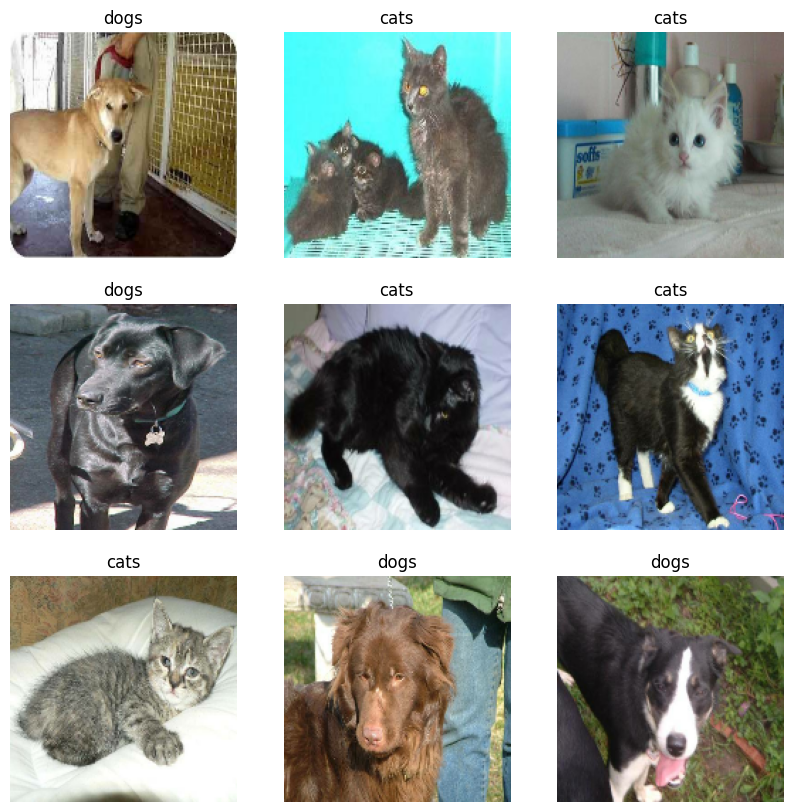

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #batches of data for validation
test_dataset = validation_dataset.take(val_batches // 5)  #make a test dataset from the validation dataset
validation_dataset = validation_dataset.skip(val_batches // 5)

In [19]:
print(val_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

tf.Tensor(32, shape=(), dtype=int64)
Number of validation batches: 26
Number of test batches: 6


In [20]:
AUTOTUNE = tf.data.AUTOTUNE #automatically determine the optimal number of elements to prefetch based on your system's performance
#performance optimization ----> makes your training pipeline faster and smoother without extra effort
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 1.2 Data augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1)
])

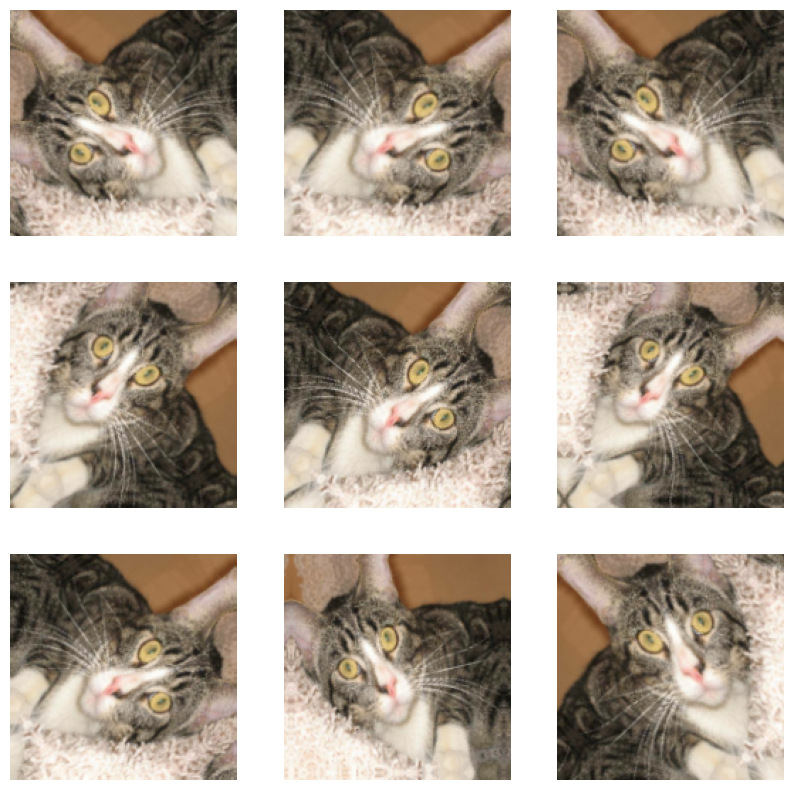

In [22]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) MODEL expects values from [-1,1]
# or rescale from[0,255] to [-1,1] with tf.keras.layers.rescaling

#2) Create base model

In [26]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,  #last layer
                                               weights='imagenet') #preloaded weights

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
image_batch, label_batch = next(iter(train_dataset))  #converts image from 160x160x3
feature_batch = base_model(image_batch)               #into 5x5x1280
print(feature_batch.shape)

(32, 5, 5, 1280)


#3) Feature extraction

In [28]:
#Freeze the convolutional base
base_model.trainable = False

In [29]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #averagepooling
feature_batch_average = global_average_layer(feature_batch)       #1280 element vector per image
print(feature_batch_average.shape)

(32, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)   #from 1280 elements to a single prediction per image

(32, 1)


#4) Completing the Model

## 4.1Build the complete model, from the base + augementation + rescaling + feature extraction leayer

In [33]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Parameters in mobilenet are frozen, but The trainable parameters in the Dense layer are changing

In [36]:
len(model.trainable_variables) # 1 weights and 2 bias

2

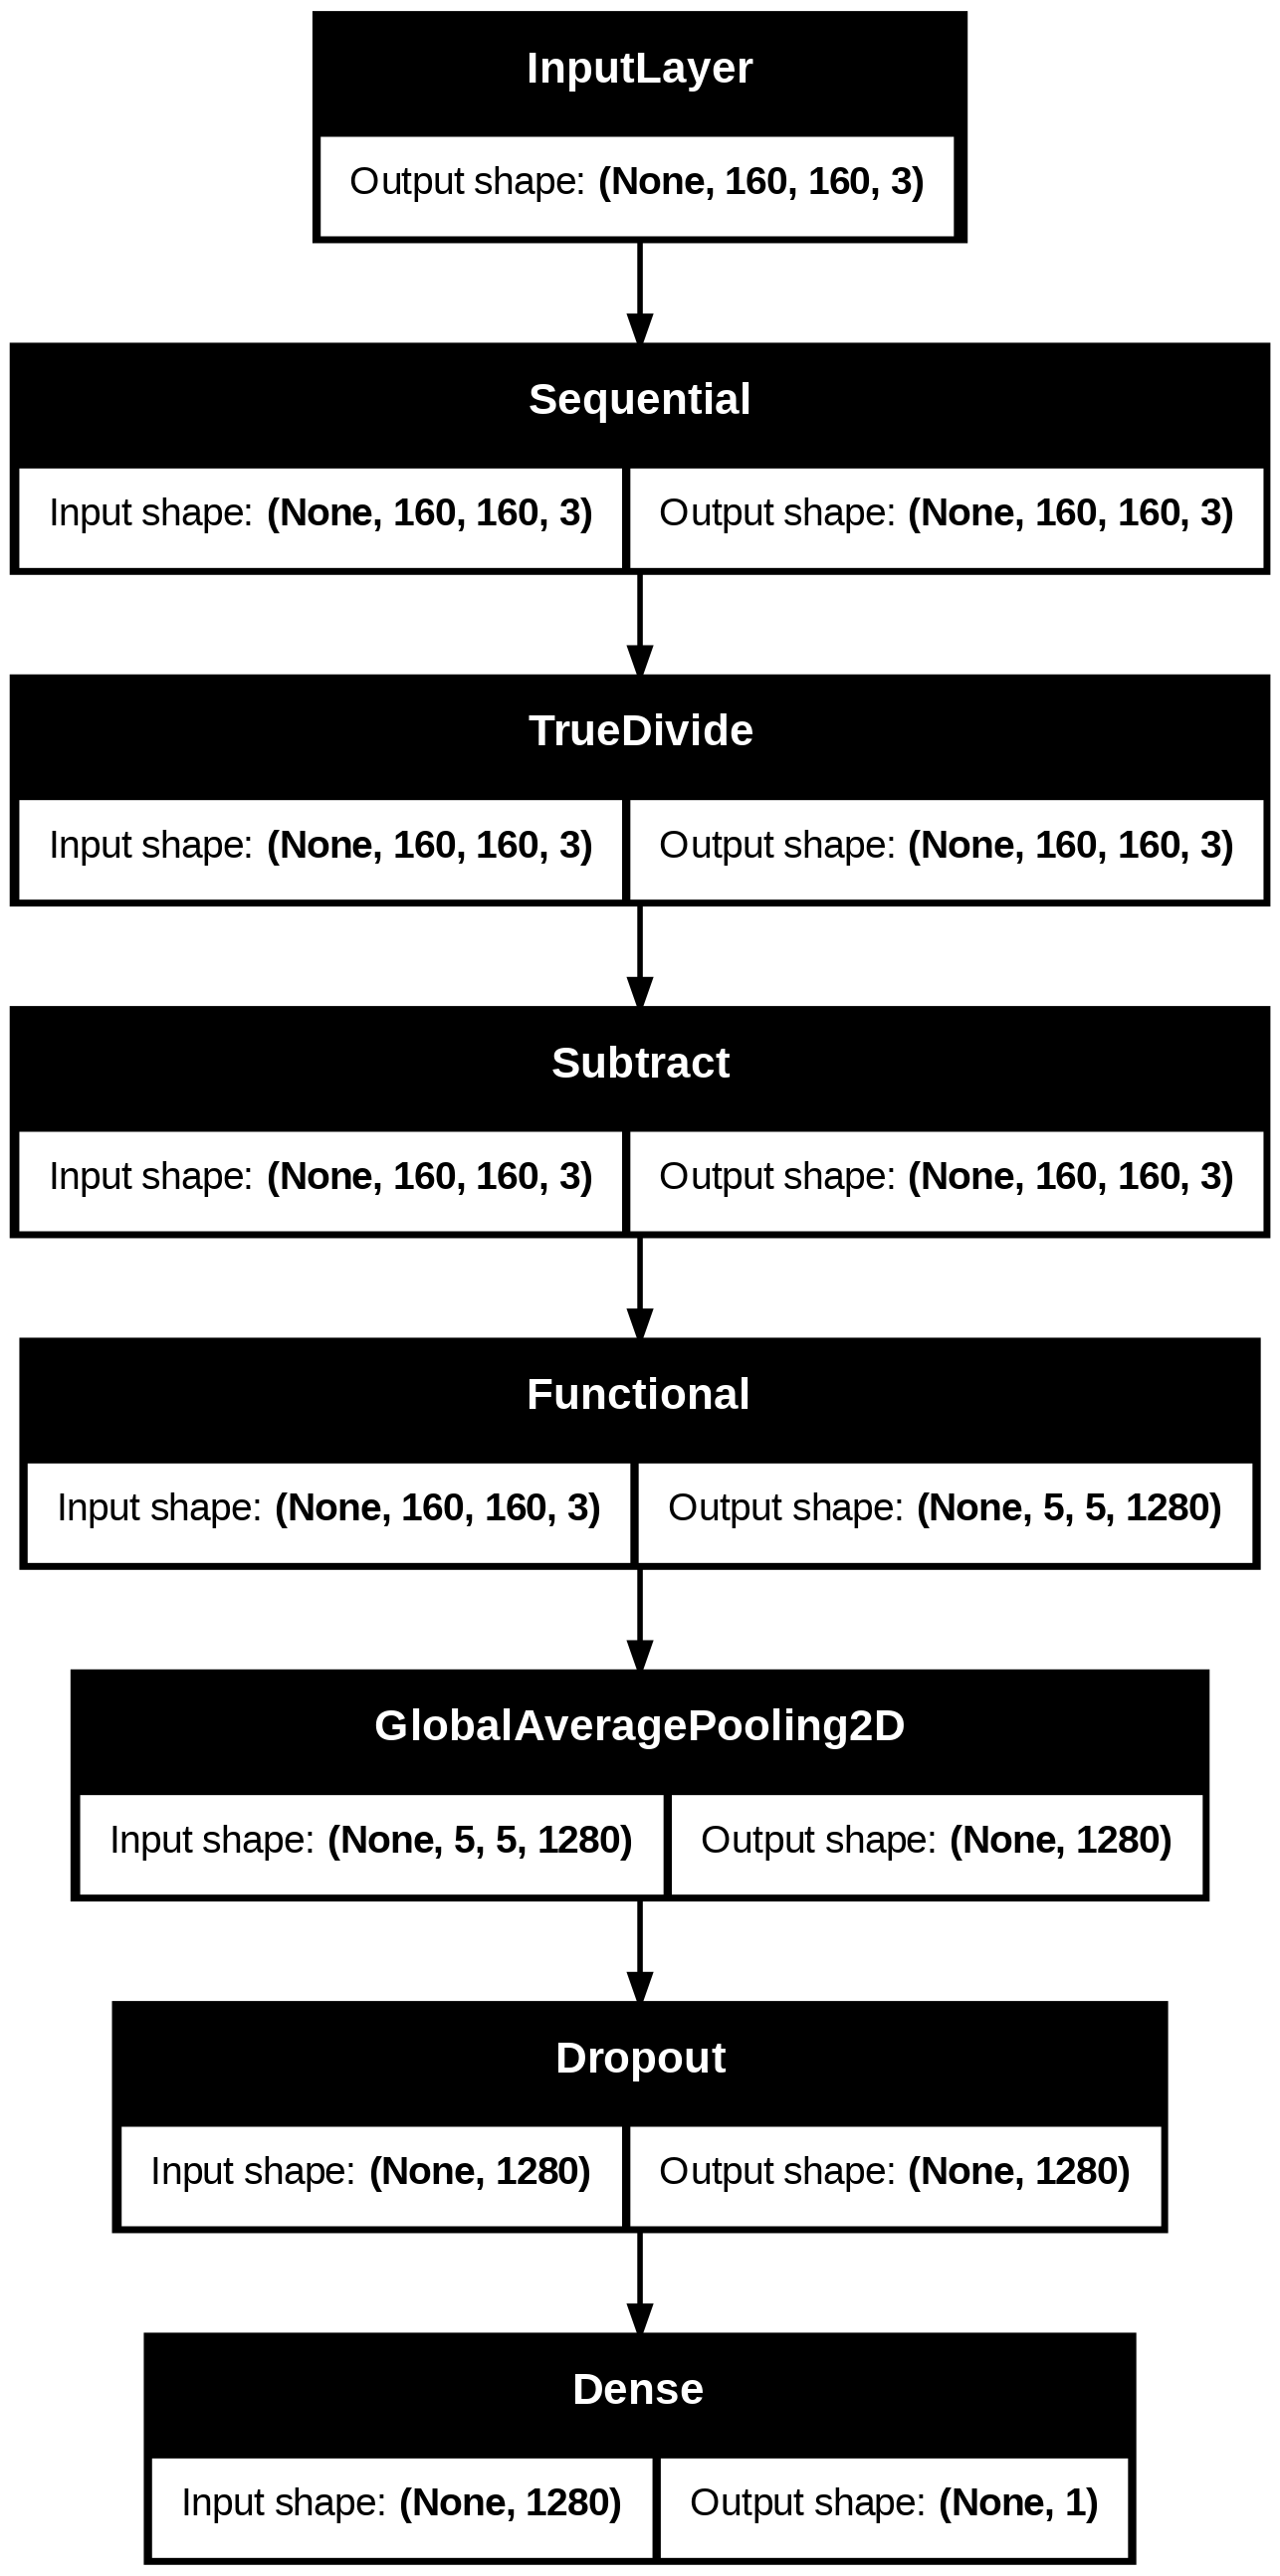

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 4.2 Compile and Train

In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [39]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 540ms/step - accuracy: 0.6771 - loss: 0.5948


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.60
initial accuracy: 0.68


In [41]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 937ms/step - accuracy: 0.5977 - loss: 0.6934 - val_accuracy: 0.8416 - val_loss: 0.4247
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7501 - loss: 0.5206 - val_accuracy: 0.9047 - val_loss: 0.3194
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 937ms/step - accuracy: 0.8176 - loss: 0.4172 - val_accuracy: 0.9295 - val_loss: 0.2537
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8709 - loss: 0.3464 - val_accuracy: 0.9418 - val_loss: 0.2143
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 948ms/step - accuracy: 0.8798 - loss: 0.3069 - val_accuracy: 0.9443 - val_loss: 0.1895
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8971 - loss: 0.2836 - val_accuracy: 0.9505 - val_loss: 0.1715
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 928ms/step - accuracy: 0.8959 - loss: 0.2556 - val_accuracy: 0.9530 - val_loss: 0.1591
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8947 - loss: 0.2491 - val_accuracy: 0.9592

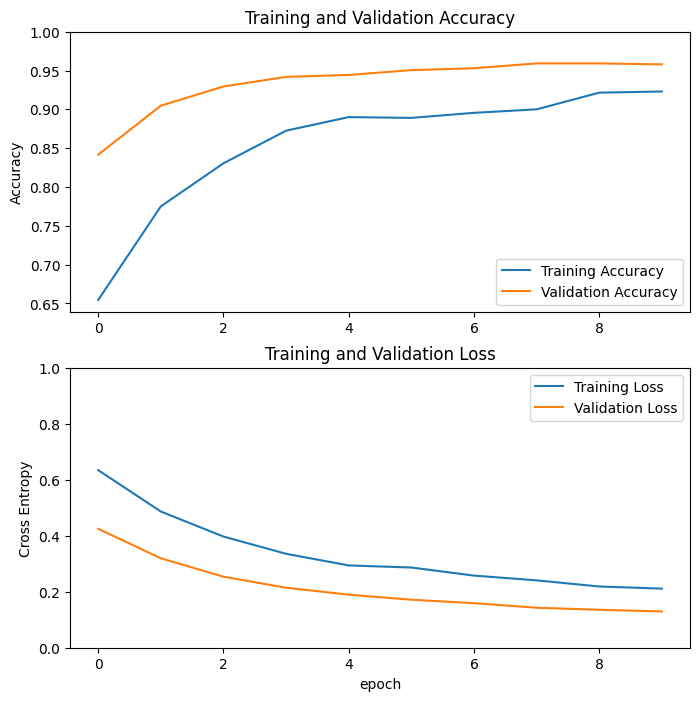

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 5) Fine tuning

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #recompile model so changes take effect
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [46]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [47]:
len(model.trainable_variables)

56

In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs   #The validation loss is much higher than the training loss, so you may get some overfitting.
                                                    #You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.
history_fine = model.fit(train_dataset,             #After fine tuning the model nearly reaches 98% accuracy on the validation set.
 epochs=total_epochs,
 initial_epoch=len(history.epoch),
 validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7888 - loss: 0.4517 - val_accuracy: 0.9765 - val_loss: 0.0878
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8905 - loss: 0.2706 - val_accuracy: 0.9777 - val_loss: 0.0715
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9102 - loss: 0.2288 - val_accuracy: 0.9814 - val_loss: 0.0614
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9351 - loss: 0.1908 - val_accuracy: 0.9814 - val_loss: 0.0594
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9128 - loss: 0.2101 - val_accuracy: 0.9790 - val_loss: 0.0570
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9300 - loss: 0.1962 - val_accuracy: 0.9790 - val_loss: 0.0539
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9467 - loss: 0.1488 - val_accuracy: 0.9802 - val_loss: 0.0530
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9492 - loss: 0.1517 - val_accuracy: 0.97

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

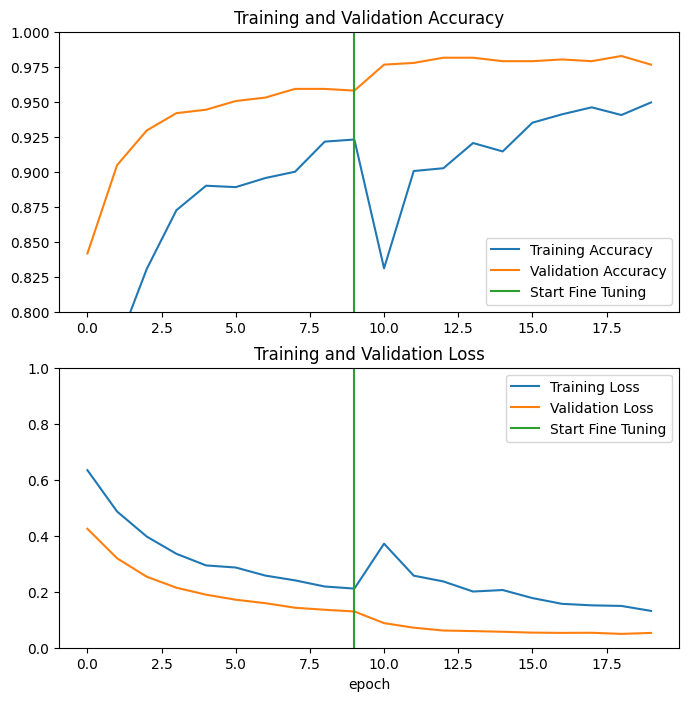

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#6) Evaluation

In [51]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 634ms/step - accuracy: 0.9786 - loss: 0.0525
Test accuracy : 0.9791666865348816


Predictions:
 [0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1]
Labels:
 [0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1]


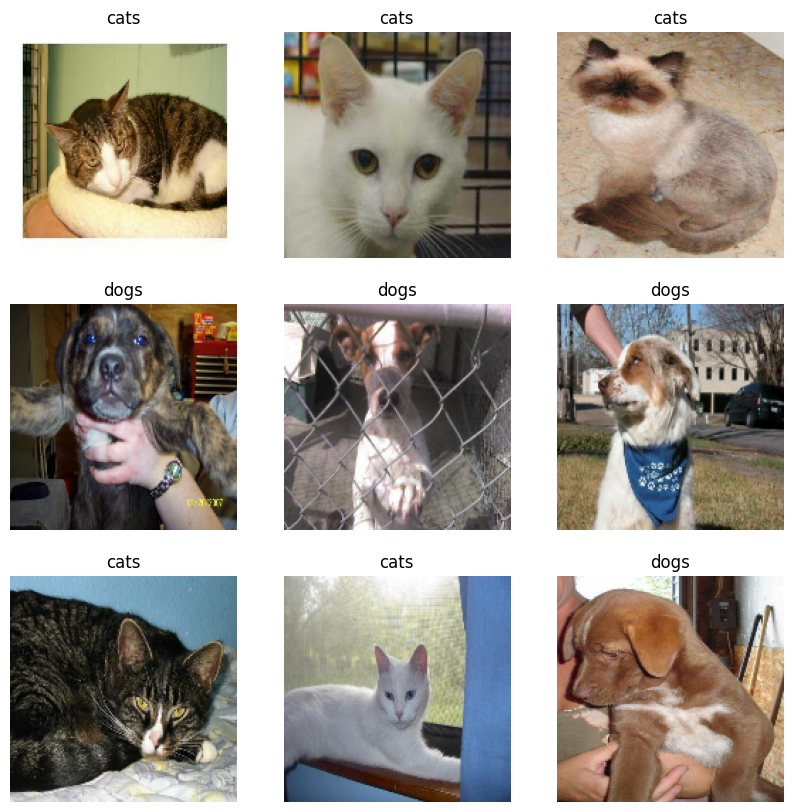

In [52]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")